Exercise 3
==========

In [1]:
import numpy
import re
from matplotlib import pyplot
from matplotlib import colors
from IPython.display import Latex, Math, display
% matplotlib inline

In [2]:
import os, sys
sys.path.append(os.path.split(os.path.split(os.getcwd())[0])[0])

In [3]:
import utils.poly as poly
import utils.quadrature as quad
import utils.elems.one_d as elem

## (a)

Construct the mass matrix $M$ using p-type modal expansion with polynomial order $P=8$ and Gauss-Lobatto-Legendre quadrature $Q=10$.

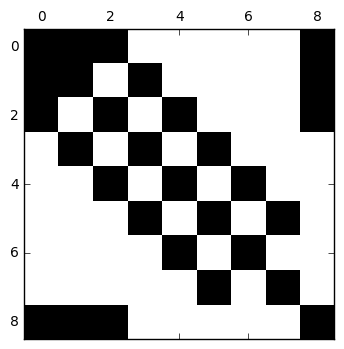

In [4]:
e1 = elem.CommonJacobiElem([-1, 1], 9)
M = numpy.where(e1.M != 0, 1, 0)
pyplot.matshow(M, cmap=colors.ListedColormap(['white', 'black']));

## (b)

Construct the mass matrix $M$ using p-type Lagrange nodal expansion and using Gauss-Lobatto-Legendre quadrature points as nodes. Check if the mass matrix is diagonal if using Gauss-Lobatto-Legendre quadrature to numerically evaluate the mass matrix.

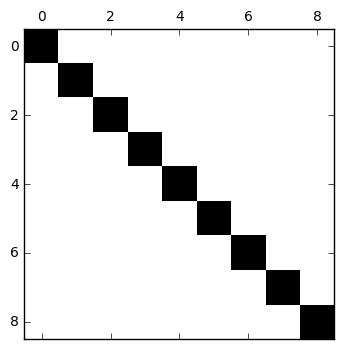

In [5]:
e2 = elem.GaussLobattoJacobiElem([-1, 1], 9)
M = numpy.where(e2.M != 0, 1, 0)
pyplot.matshow(M, cmap=colors.ListedColormap(['white', 'black']));

## (c)

Consider the projection problem, $u(x) = \sum_{i=0}^{P}u_i\phi_i(x) = f(x)$, where $f(x)=x^7$ and $-1 \le x \le 1$. The weighted residual equation will be:

$$
\int_{-1}^{1} \phi_i(x)\left[\sum_{j=0}^{P}u_j\phi_j(x)\right]dx =
\int_{-1}^{1} \phi_i(x)f(x)dx \text{, and }i=0\ to\ P
$$

Using the mass matrices we built in (a) and (b), we can generate a system of linear equations:
$$
\mathbf{M}\mathbf{u} = \mathbf{f}
$$

Solve the unknowns $\mathbf{u}$ and compare the error of $u(x)=\sum_{i=0}^{P}u_i\phi_i(x)$ against $f(x)=x^7$.

We first define a function to represent the behavior of $u(x)=\sum_{i=0}^{P}u_i\phi_i(x)$.

In [6]:
def u(x, expn, Ui):
    """return the result of approximations"""
    
    ans = numpy.array([ui * expn[i](x) for i, ui in enumerate(Ui)])
    
    return ans.sum(axis=0)

And then solve the $\mathbf{u}$ using the two different expansion in part (a) and (b).

In [7]:
qd = quad.GaussLobattoJacobi(10)
f = poly.Polynomial(roots=[0, 0, 0, 0, 0, 0, 0])

e1 = elem.CommonJacobiElem([-1, 1], 9)
e2 = elem.GaussLobattoJacobiElem([-1, 1], 9)

fi1 = numpy.array([qd(e1.expn[i] * f) for i in range(9)])
ui1 = numpy.linalg.solve(e1.M, fi1)

fi2 = numpy.array([qd(e2.expn[i] * f) for i in range(9)])
ui2 = numpy.linalg.solve(e2.M, fi2)

e1.set_ui(ui1)
e2.set_ui(ui2)

Calculate the error between the interval $x \in [-1, 1]$.

In [8]:
x = numpy.linspace(-1, 1, 100)

err1 = numpy.abs(e1(x) - f(x))
err2 = numpy.abs(e2(x) - f(x))

l2norm1 = numpy.linalg.norm(err1, 2)
l2norm2 = numpy.linalg.norm(err2, 2)

print(l2norm1)
print(l2norm2)

6.90490415032e-14
9.0682828041e-14


## (d)

Now we consider only the the *lifted* problem. That is, we decouple the boundary mode and interior mode:
$$u(x) = u^D(x) + u^{H}(x)$$

where
$$u^{D}(x) = u(-1)\phi_0(x) + u(1)\phi_P(x) = u_0\phi_0(x) + u_P\phi_P(x)$$
and
$$u^{H}(x) = \sum_{i=1}^{P-1} u_i\phi_i(x)$$

The weighted residual equation becomes

$$
\int_{-1}^{1} \phi_i(x)\left[\sum_{j=1}^{P-1}u_j\phi_j(x)\right]dx = 
\int_{-1}^{1} \phi_i(x)f(x)dx - 
\int_{-1}^{1} \phi_i(x)\left[u_0\phi_0(x) + u_P\phi_P(x)\right]dx
\text{, for }
1 \le i \le P-1
$$

or in the form of mass matrix:

$$
\mathbf{M}_{ij}\mathbf{u}_j =
\mathbf{f}_i - 
u_0\mathbf{M}_{i0} - 
u_{P}\mathbf{M}_{iP}
\text{, for }
1 \le i,\ j \le P-1
$$

In [9]:
qd = quad.GaussLobattoJacobi(10)
f = poly.Polynomial(roots=[0, 0, 0, 0, 0, 0, 0])

e1 = elem.CommonJacobiElem([-1, 1], 9)
e2 = elem.GaussLobattoJacobiElem([-1, 1], 9)

ui1 = numpy.zeros(9, dtype=numpy.float64)
ui2 = numpy.zeros(9, dtype=numpy.float64)
ui1[0] = ui2[0] = f(-1)
ui1[-1] = ui2[-1] = f(1)

fi1 = numpy.array([e1.expn[i](qd.nodes) * f(qd.nodes) * qd.weights
                   for i in range(1, 8)]).sum(axis=1) - \
    numpy.array(e1.M[1:-1, 0] * ui1[0] + e1.M[1:-1, -1] * ui1[-1]).flatten()
ui1[1:-1] = numpy.linalg.solve(e1.M[1:-1, 1:-1], fi1)

fi2 = numpy.array([e2.expn[i](qd.nodes) * f(qd.nodes) * qd.weights
                   for i in range(1, 8)]).sum(axis=1) - \
    numpy.array(e2.M[1:-1, 0] * ui2[0] + e2.M[1:-1, -1] * ui2[-1]).flatten()
ui2[1:-1] = numpy.linalg.solve(e2.M[1:-1, 1:-1], fi2)

e1.set_ui(ui1)
e2.set_ui(ui2)

In [10]:
x = numpy.linspace(-1, 1, 100)

err1 = numpy.abs(e1(x) - f(x))
err2 = numpy.abs(e2(x) - f(x))

l2norm1 = numpy.linalg.norm(err1, 2)
l2norm2 = numpy.linalg.norm(err2, 2)

print(l2norm1)
print(l2norm2)

6.76195817976e-14
8.93416778132e-14


## (e)

The same problem as in the part (c) except that now the function $f(x)$ is defined on interval $[2, 5]$. Use chain rule to handle this situation.

In [11]:
xmin = 2.
xMax = 5.

qd = quad.GaussLobattoJacobi(10)
f = poly.Polynomial(roots=[0, 0, 0, 0, 0, 0, 0])

e1 = elem.CommonJacobiElem([xmin, xMax], 9)
e2 = elem.GaussLobattoJacobiElem([xmin, xMax], 9)

ui1 = numpy.zeros(9, dtype=numpy.float64)
ui2 = numpy.zeros(9, dtype=numpy.float64)
ui1[0] = ui2[0] = f(xmin)
ui1[-1] = ui2[-1] = f(xMax)

fi1 = numpy.array([e1.expn[i](qd.nodes) * f(e1.xi_to_x(qd.nodes)) * qd.weights
                   for i in range(1, 8)]).sum(axis=1) - \
    numpy.array(e1.M[1:-1, 0] * ui1[0] + e1.M[1:-1, -1] * ui1[-1]).flatten()
ui1[1:-1] = numpy.linalg.solve(e1.M[1:-1, 1:-1], fi1)

fi2 = numpy.array([e2.expn[i](qd.nodes) * f(e2.xi_to_x(qd.nodes)) * qd.weights
                   for i in range(1, 8)]).sum(axis=1) - \
    numpy.array(e2.M[1:-1, 0] * ui2[0] + e2.M[1:-1, -1] * ui2[-1]).flatten()
ui2[1:-1] = numpy.linalg.solve(e2.M[1:-1, 1:-1], fi2)

e1.set_ui(ui1)
e2.set_ui(ui2)

In [12]:
x = numpy.linspace(xmin, xMax, 100)

err1 = numpy.abs(e1(x) - f(x))
err2 = numpy.abs(e2(x) - f(x))

l2norm1 = numpy.linalg.norm(err1, 2)
l2norm2 = numpy.linalg.norm(err2, 2)

print(l2norm1)
print(l2norm2)

4.65695482856e-09
4.30273328902e-09
